## Initial Setup

In [ ]:
import os
import math
import glob
import numpy as np
import pandas as pd
from math import sqrt
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Dense, LSTM, RepeatVector, Dropout
from tensorflow.keras.layers import Concatenate, TimeDistributed
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import regularizers
from tensorflow.keras import Model
from tensorflow.keras.losses import Loss

## Dataset generation

These cells can be skipped if data is already generated and stored in npy format.

In [ ]:
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt

# Parameters
Lx = 10.0      # Length of the domain in the x direction
Ly = 10.0      # Length of the domain in the y direction
Nx = 28        # Number of spatial points in the x direction
Ny = 28        # Number of spatial points in the y direction
Nt = 4000      # Number of time steps
D_a = 0.01     # Diffusion coefficient for variable a
D_b = 0.01     # Diffusion coefficient for variable b
D_c = 0.01     # Diffusion coefficient for variable c (combination of a and b)
alpha = 0.1    # Influence of variable_a on variable_b
beta = 0.2     # Coefficient for variable_a in variable_c
gamma = 0.3    # Coefficient for variable_b in variable_c
neighborhood_size = 3  # Size of the neighborhood for convolution
lag_a = 1      # Lag for variable_a
lag_b = 1      # Lag for variable_b
update_factor_b = 0.6  # Update factor for variable_b

# Spatial and temporal discretization
x = np.linspace(0, Lx, Nx)
y = np.linspace(0, Ly, Ny)
X, Y = np.meshgrid(x, y)
dx = x[1] - x[0]
dy = y[1] - y[0]

# Time discretization
dt = 0.01      # Time step
t = np.linspace(0, Nt * dt, Nt)

# Initialize variables
variable_a = np.zeros((Nt, Nx, Ny))
variable_b = np.zeros((Nt, Nx, Ny))
variable_b_cf = np.zeros((Nt, Nx, Ny))
variable_c = np.zeros((Nt, Nx, Ny))
variable_c_cf = np.zeros((Nt, Nx, Ny))

# Initial conditions
variable_a[0, :, :] = np.exp(-((X - Lx/2)**2 + (Y - Ly/2)**2) / 4)
variable_b[0, :, :] = np.sin(np.pi * X / Lx) + alpha * variable_a[0, :, :]
#variable_b_cf[0, :, :] = np.cos(np.pi * X / Lx) + alpha * variable_a[0, :, :]
variable_c[0, :, :] = beta * variable_a[0, :, :] + gamma * variable_b[0, :, :]
variable_c_cf[0, :, :] = beta * variable_a[0, :, :] + gamma * variable_b[0, :, :]

# Time-stepping loop
for n in range(1, Nt):
    # Diffusion Equation for variable_a with time lag
    laplacian_a = (np.roll(variable_a[n-1, :, :], 1, axis=1) - 2 * variable_a[n-1, :, :] + np.roll(variable_a[n-1, :, :], -1, axis=1)) / dx**2 + \
                   (np.roll(variable_a[n-1, :, :], 1, axis=0) - 2 * variable_a[n-1, :, :] + np.roll(variable_a[n-1, :, :], -1, axis=0)) / dy**2
    diffusion_term_a = D_a * laplacian_a
    variable_a[n, :, :] = variable_a[n-1, :, :] + dt * diffusion_term_a

    # Diffusion Equation for variable_b with time lag and dependence on lagged variable_a
    laplacian_b = (np.roll(variable_b[n-1, :, :], 1, axis=1) - 2 * variable_b[n-1, :, :] + np.roll(variable_b[n-1, :, :], -1, axis=1)) / dx**2 + \
                   (np.roll(variable_b[n-1, :, :], 1, axis=0) - 2 * variable_b[n-1, :, :] + np.roll(variable_b[n-1, :, :], -1, axis=0)) / dy**2
    diffusion_term_b = D_b * laplacian_b
    variable_b[n, :, :] = (variable_b[n-1, :, :] + dt * (diffusion_term_b + alpha * np.roll(diffusion_term_a, lag_a, axis=(0, 1))))
    variable_b_cf[n, :, :] = (variable_b[n-1, :, :] + dt * (diffusion_term_b + alpha * np.roll(diffusion_term_a, lag_a, axis=(0, 1))))

    variable_b_cf[n,10:15,10:15] = update_factor_b * variable_b_cf[n,10:15,10:15]

    # Convolution to compute the mean of per-pixel neighborhood of variable_b (excluding the pixel itself)
    kernel_size = 3
    neighborhood_sum = scipy.ndimage.convolve(variable_b[n, :, :], np.ones((kernel_size, kernel_size)), mode='constant', cval=0)
    neighborhood_mean = (neighborhood_sum - variable_b[n, :, :]) / (kernel_size**2 - 1)

    # Diffusion Equation for variable_c with time lag and dependence on lagged variable_a and lagged variable_b
    laplacian_c = (np.roll(variable_c[n-1, :, :], 1, axis=1) - 2 * variable_c[n-1, :, :] + np.roll(variable_c[n-1, :, :], -1, axis=1)) / dx**2 + \
                   (np.roll(variable_c[n-1, :, :], 1, axis=0) - 2 * variable_c[n-1, :, :] + np.roll(variable_c[n-1, :, :], -1, axis=0)) / dy**2
    diffusion_term_c = D_c * laplacian_c
    variable_c[n, :, :] = variable_c[n-1, :, :] + dt * diffusion_term_c + beta * dt * np.roll(diffusion_term_a, lag_a, axis=(0, 1)) + gamma * dt * (np.roll(variable_b[n, :, :], lag_b, axis=(0, 1)) + neighborhood_mean)

#variable_b_cf = np.copy(variable_b)
#variable_b_cf[:,10:20,10:20] = variable_b_cf[:,10:20,10:20] * 1.5

for n in range(1, Nt):
  # Diffusion Equation for variable_c with time lag and dependence on lagged variable_a and lagged variable_b
    laplacian_cf = (np.roll(variable_c_cf[n-1, :, :], 1, axis=1) - 2 * variable_c_cf[n-1, :, :] + np.roll(variable_c_cf[n-1, :, :], -1, axis=1)) / dx**2 + \
                   (np.roll(variable_c_cf[n-1, :, :], 1, axis=0) - 2 * variable_c_cf[n-1, :, :] + np.roll(variable_c_cf[n-1, :, :], -1, axis=0)) / dy**2
    diffusion_term_cf = D_c * laplacian_cf
    variable_c_cf[n, :, :] = variable_c_cf[n-1, :, :] + dt * diffusion_term_cf + beta * dt * np.roll(diffusion_term_a, lag_a, axis=(0, 1)) + gamma * dt * (np.roll(variable_b_cf[n, :, :], lag_b, axis=(0, 1)) + neighborhood_mean)


In [ ]:
from copy import copy, deepcopy

a = variable_a.reshape(4000, 28, 28, 1)
b = variable_b.reshape(4000, 28, 28, 1)
c = variable_c.reshape(4000, 28, 28, 1)
c_cf = variable_c_cf.reshape(4000, 28, 28, 1)

b_tr = deepcopy(b)
b_tr[:,10:15,10:15,0] = b_tr[:,10:15,10:15,0]*0.6

data_wouts = np.concatenate([a, b, c, b_tr, c_cf], 3)
print(data_wouts.shape)

(4000, 28, 28, 5)


In [ ]:
idx = np.where((b - b_tr) > 0)

(100000,)

Padding zeros to make data divisible into chunks of 5x5

In [ ]:
data_wouts_30 = np.zeros((4000,30,30,5))
data_wouts_30[:,:28,:28,:] = data_wouts

## Callable Functions





In [ ]:
"""
This function add lags to the dataset and divides data into different features

Input: dataset, lag and the indexes of the variables identified at treatment and target
Output: Individual features such as lagged treatment, treatment history, covariates history, target history, target and counterfactual values
"""

def lagged_data_parser(data, lag, tr_id, target_id,cf_id=-1):
  tr = data[1:-lag,:, :, tr_id]
  tr_hist = data[:-(lag+1),:,:,tr_id]
  #extracting covariates as remaining variables
  temp = data.copy()
  temp = np.delete(temp,(tr_id,target_id,3,cf_id), 3)
  cov = temp[:-(lag+1),:,:,:]
  cov = cov.reshape(cov.shape[:-1])
  target_hist = data[:-(lag+1),:,:,target_id] #this variable helps in time-series forecasting as an input feature
  target = data[lag+1:,:,:,target_id] #factual data
  cf = data[lag+1:,:,:,cf_id] # counterfactual data
  tr_treated = data[1:-lag,:, :, 3]
  return tr, tr_hist, cov, target_hist, target, cf, tr_treated

In [ ]:
#convert data into 5x5 block and flatten
def transform_5x5_block(tr, tr_hist, cov, target_hist, target, cf, tr_treated):
  tr_5x5, tr_hist_5x5, cov_5x5, target_hist_5x5, target_5x5, cf_5x5, tr_treated_5x5 = [np.zeros((3998*36,5,5,1)) for _ in range(7)]
  count = 0
  for i in range (tr.shape[0]):
    for j in range(6):
      for k in range(6):
        x=j*5
        y=k*5
        #print(count, i, x, y)
        tr_5x5[count,:,:,0]=tr[i,x:x+5,y:y+5]
        tr_hist_5x5[count,:,:,0]=tr_hist[i,x:x+5,y:y+5]
        cov_5x5[count,:,:,0]=cov[i,x:x+5,y:y+5]
        target_hist_5x5[count,:,:,0]=target_hist[i,x:x+5,y:y+5]
        target_5x5[count,:,:,0]=target[i,x:x+5,y:y+5]
        cf_5x5[count,:,:,0]=cf[i,x:x+5,y:y+5]
        tr_treated_5x5[count,:,:,0]=tr_treated[i,x:x+5,y:y+5]
        count=count+1
  return tr_5x5, tr_hist_5x5, cov_5x5, target_hist_5x5, target_5x5, cf_5x5, tr_treated_5x5

###Concatenate history block and intervention block

In [ ]:
def intervention_data_loader(tr, tr_hist, target_hist, cov):

  hist = np.concatenate([tr_hist, cov], 2) #joint history of treatment and covariates
  inter = np.concatenate([tr, target_hist], 2) #treatment and target history
  print(hist.shape, inter.shape)
  return hist, inter

### Train Validation Split

In [ ]:
# Copy last 30% sequential data for test and for treatment

def train_test_treat_splitter(hist, inter, target, tr_treated):
  hist_train = hist
  inter_train = inter
  target_train = target

  hist_test = hist
  inter_test = inter
  target_test = target #target is last column

  #Create treated and untreated versions of test data
  treated = inter_test.copy()
  treated[:,:,0] = tr_treated[:,:,0] #increasing the treatment by 10%

  print('hist.shape:',hist.shape)
  print('inter.shape:',inter.shape)
  print('target.shape:',target.shape)
  print('hist_test.shape:',hist_test.shape)
  print('inter_test.shape:',inter_test.shape)
  print('target_test.shape:',target_test.shape)
  print('treated.shape:',treated.shape)

  return hist_train, inter_train, target_train, hist_test, inter_test, target_test, treated

### Normalization


In [ ]:
# normalize the features
#features = 4
def data_normalizer(hist, hist_test, inter, inter_test, treated, target, target_test):
  scaler_f = StandardScaler()
  hist_n = scaler_f.fit_transform(hist.reshape(-1,hist.shape[2])) #reshaping to 2d for standard scaling
  hist_test_n = scaler_f.transform(hist_test.reshape(-1,hist.shape[2])) #reshaping to 2d for standard scaling
  hist_n = hist_n.reshape(hist.shape)
  hist_test_n = hist_test_n.reshape(hist_test.shape)

  scaler_tr = StandardScaler()
  inter_n = scaler_tr.fit_transform(inter.reshape(-1,inter.shape[2])) #reshaping to 2d for standard scaling
  inter_test_n = scaler_tr.transform(inter_test.reshape(-1,inter.shape[2])) #reshaping to 2d for standard scaling
  treated_n = scaler_tr.transform(treated.reshape(-1,2)) #reshaping to 2d for standard scaling
  inter_n = inter_n.reshape(inter.shape)
  inter_test_n = inter_test_n.reshape(inter_test.shape)
  treated_n = treated_n.reshape(treated.shape)

  scaler_l = StandardScaler()
  target_n = scaler_l.fit_transform(target.reshape(-1,1)) #reshaping to 2d for standard scaling
  target_test_n = scaler_l.transform(target_test.reshape(-1,1)) #reshaping to 2d for standard scaling
  target_n = target_n.reshape(target.shape[:-1])
  target_test_n = target_test_n.reshape(target_test.shape[:-1])
  return scaler_f, scaler_tr, scaler_l, hist_n, hist_test_n, inter_n, inter_test_n, treated_n, target_n, target_test_n

### Reshaping Input and Target Features

In [ ]:
# convert an array of values into a dataset matrix
def reshape_features(dataset, timesteps=1):
    print(dataset.shape)
    X = dataset.reshape((int(dataset.shape[0]/timesteps)), timesteps, dataset.shape[1])
    return X

### Specifying the loss function

In [ ]:
# We will use the MSE loss function as base loss
loss_fn = tf.keras.losses.MeanSquaredError() #specify the loss

### Building Model

In [ ]:
def build_mtcinet_model(input1_shape, input2_shape, out_dim1, out_dim2, loss):
  input1 = Input(shape=input1_shape)
  input2 = Input(shape=input2_shape)

  model1_enc = LSTM(64, return_sequences=True)(input1)
  model1_enc = Dropout(0.2)(model1_enc)
  model1_enc = LSTM(32, return_sequences=False)(model1_enc)
  phi = Dense(16)(model1_enc)

  model1_dec = RepeatVector(25)(phi)
  model1_dec = LSTM(64, return_sequences=True)(model1_dec)
  history = LSTM(out_dim1, return_sequences=True)(model1_dec)

  model2 = LSTM(64, return_sequences=True)(input2)
  model2 = Dropout(0.2)(model2)
  model2 = LSTM(32, return_sequences=False)(model2)
  #model2 = Attention()(model2)
  omega = Dense(16)(model2)

  merger = Concatenate(axis=1)([phi, omega])
  merged_model = Dense(16)(merger)
  outcome = Dense(out_dim2, name="outcome")(merged_model)
  model = Model(inputs=[input1,input2], outputs=[history, outcome])
  #Compiling the network
  model.compile(loss=loss, optimizer='adam')
  return model

## Train Model Block

In [ ]:
#file = 'synthetic_data_nonlinear_continuous_lag5.csv'
#data = data_loader(file)
data = data_wouts_30

# Input to take from user on the given dataset
is_synth_data = 1 #flag to check if data is synthetic. Modules dont search for or read cf variable in case of real dataset
lag = 1
tr_factor = 0.6# 1.1 #multiplicative factor for treatment
tr_id = 1
target_id = 2
timesteps = 1 #window size for Model

print("--------------------------------------------------------------------------")
print("Running experiment for Treatment_ID: "+str(tr_id)+" and Outcome_ID: "+ str(target_id))
print("--------------------------------------------------------------------------")

#Create a 4 by 4 Adjacency Matrix to Store the ATE values
#ate_matrix = np.zeros((data.shape[1]-1, data.shape[1]-1))
#print(ate_matrix)

tr, tr_hist, cov, target_hist, target, cf, tr_treated = lagged_data_parser(data, lag, tr_id, target_id, cf_id=-1) # add lag to treatment and target
print(tr.shape, tr_hist.shape, cov.shape, target_hist.shape, target.shape, cf.shape, tr_treated.shape)

# create 5x5 data block
tr_5x5, tr_hist_5x5, cov_5x5, target_hist_5x5, target_5x5, cf_5x5, tr_treated_5x5 = transform_5x5_block(tr, tr_hist, cov, target_hist, target, cf, tr_treated)

#flatten the 5x5 into 25 timesteps
tr_5x5_f = tr_5x5.reshape(tr_5x5.shape[0], -1, tr_5x5.shape[3])
tr_hist_5x5_f = tr_hist_5x5.reshape(tr_hist_5x5.shape[0], -1, tr_hist_5x5.shape[3])
cov_5x5_f = cov_5x5.reshape(cov_5x5.shape[0], -1, cov_5x5.shape[3])
target_hist_5x5_f = target_hist_5x5.reshape(target_hist_5x5.shape[0], -1, target_hist_5x5.shape[3])
target_5x5_f = target_5x5.reshape(target_5x5.shape[0], -1, target_5x5.shape[3])
cf_5x5_f = cf_5x5.reshape(cf_5x5.shape[0], -1, cf_5x5.shape[3])
tr_treated_5x5_f = tr_treated_5x5.reshape(tr_treated_5x5.shape[0], -1, tr_treated_5x5.shape[3])

print(tr_5x5_f.shape, tr_hist_5x5_f.shape, cov_5x5_f.shape, target_hist_5x5_f.shape, target_5x5_f.shape, cf_5x5_f.shape, tr_treated_5x5_f.shape)

hist, inter = intervention_data_loader(tr_5x5_f, tr_hist_5x5_f, target_hist_5x5_f, cov_5x5_f)
hist_train, inter_train, target_train, hist_test, inter_test, target_test, treated = train_test_treat_splitter(hist, inter, target_5x5_f, tr_treated_5x5_f)
scaler_f, scaler_tr, scaler_l, hist_train_n, hist_test_n, inter_train_n, inter_test_n, treated_n, target_train_n, target_test_n = data_normalizer(hist_train, hist_test, inter_train, inter_test, treated, target_train, target_test)

print("hist_train, hist_test, inter_train, inter_test, treated",(hist_train_n.shape, hist_test_n.shape, inter_train_n.shape, inter_test_n.shape, treated_n.shape,target_train_n.shape, target_test_n.shape))



--------------------------------------------------------------------------
Running experiment for Treatment_ID: 1 and Outcome_ID: 2
--------------------------------------------------------------------------
(3998, 30, 30) (3998, 30, 30) (3998, 30, 30) (3998, 30, 30) (3998, 30, 30) (3998, 30, 30) (3998, 30, 30)
(143928, 25, 1) (143928, 25, 1) (143928, 25, 1) (143928, 25, 1) (143928, 25, 1) (143928, 25, 1) (143928, 25, 1)
(143928, 25, 2) (143928, 25, 2)
hist.shape: (143928, 25, 2)
inter.shape: (143928, 25, 2)
target.shape: (143928, 25, 1)
hist_test.shape: (143928, 25, 2)
inter_test.shape: (143928, 25, 2)
target_test.shape: (143928, 25, 1)
treated.shape: (143928, 25, 2)
hist_train, hist_test, inter_train, inter_test, treated ((143928, 25, 2), (143928, 25, 2), (143928, 25, 2), (143928, 25, 2), (143928, 25, 2), (143928, 25), (143928, 25))


In [ ]:
loss_fn = tf.keras.losses.MeanSquaredError() #specify the loss
input1_shape = (hist_train_n.shape[1:])
input2_shape = (inter_train_n.shape[1:])
out_dim1 = hist_train_n.shape[2]
out_dim2 = 25
model = build_mtcinet_model(input1_shape, input2_shape, out_dim1, out_dim2, loss_fn)
print(model.summary())
checkpoint_path='./mymodel.h'
keras_callbacks   = [
      EarlyStopping(monitor='val_loss', patience=6, mode='min', min_delta=0.001),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')
]
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, to_file='slearner.png')

from IPython.display import Image # this just Jupyter notebook stuff
Image(retina=True, filename='slearner.png')

history=model.fit(x =[hist_train_n,inter_train_n],y=[hist_train_n,target_train_n], epochs=200, batch_size=64, verbose=2, validation_split=0.2, shuffle=False,callbacks=keras_callbacks)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 25, 2)]              0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 25, 2)]              0         []                            
                                                                                                  
 lstm (LSTM)                 (None, 25, 64)               17152     ['input_1[0][0]']             
                                                                                                  
 lstm_4 (LSTM)               (None, 25, 64)               17152     ['input_2[0][0]']             
                                                                                              

## Causal Effect Estimation (Without Spatial Interference)
The same code can be re-used for causal inference with spatial interference.

In [ ]:
import pandas as pd
import numpy as np

hist_train_p, train_pred = model.predict([hist_train_n,inter_train_n])
hist_pred, test_pred = model.predict([hist_test_n,inter_test_n])
_, cf_pred = model.predict([hist_test_n,treated_n])

4498/4498 [==============================] - 30s 7ms/step


In [ ]:
print(hist_train_p.shape, hist_test_n.shape, train_pred.shape, test_pred.shape,cf_pred.shape)

(143928, 25, 2) (143928, 25, 2) (143928, 25) (143928, 25) (143928, 25)


In [ ]:
#RMSE Outcome Model
from sklearn.metrics import mean_squared_error
from math import sqrt

test_pred_r = test_pred.reshape((-1,1))
target_test_r = target_test_n.reshape((-1,1))

inv_test_pred = scaler_l.inverse_transform(test_pred_r)
inv_target_test = scaler_l.inverse_transform(target_test_r)

#test_pred_r = test_pred_r.reshape(test_pred.shape)
#target_test_r = target_test_r.reshape(target_test.shape)

rmse = sqrt(mean_squared_error(inv_target_test, inv_test_pred))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 6.497


In [ ]:
cf_pred_r = cf_pred.reshape((-1,1))
inv_cf_pred = scaler_l.inverse_transform(cf_pred_r)

test = inv_test_pred.reshape(test_pred.shape)
cf = inv_cf_pred.reshape(cf_pred.shape)

cate_pred = np.array(cf-test)
cate_true= np.array(cf_5x5_f-target_5x5_f).reshape((cf_5x5_f.shape[0],cf_5x5_f.shape[1]))

ate_pred=np.mean(cate_pred)
ate_true=np.mean(cate_true)


In [ ]:
print("True ATE:",ate_true)
print("Estimated ATE:",ate_pred)

True ATE: -0.08138817545227248
Estimated ATE: -0.09622074


In [ ]:
pehe=np.mean(np.power((cate_true - cate_pred),2))
sqrt_pehe=np.sqrt(pehe)
print("\nSQRT PEHE:",sqrt_pehe)


SQRT PEHE: 0.5564931058857276


In [ ]:
test_1 = test.reshape((test.shape[0],5,5))
#test_pred_r_1_lf = np.zeros((test_pred_r_1.shape[0]+1,5,5))
#test_pred_r_1_lf[1:,:,:] = test_pred_r_1
test_pred_r_30 = np.zeros(data_wouts_30.shape[0:3])


count = 0
for i in range (test_pred_r_30.shape[0]-2):
  for j in range(6):
    for k in range(6):
      x=j*5
      y=k*5
      #print(count, i, x, y)
      test_pred_r_30[i,x:x+5,y:y+5] = test_1[count,:,:]
      count=count+1

In [ ]:
cf_1 = cf.reshape((cf.shape[0],5,5))
cf_pred_r_30 = np.zeros(data_wouts_30.shape[0:3])



count = 0
for i in range (cf_pred_r_30.shape[0]-2):
  for j in range(6):
    for k in range(6):
      x=j*5
      y=k*5
      #print(count, i, x, y)
      cf_pred_r_30[i,x:x+5,y:y+5] = cf_1[count,:,:]
      count=count+1

In [ ]:
test_pred_r_28 = test_pred_r_30[:,:28,:28]
cf_pred_r_28 = cf_pred_r_30[:,:28,:28]

In [ ]:
#For ATE on treated region
cate_pred_tr=(cf_pred_r_28[:3998,10:15, 10:15] - test_pred_r_28[:3998,10:15, 10:15]).squeeze()
cate_true_tr=(data_wouts[2:,10:15,10:15,4]-data_wouts[2:,10:15,10:15,2]).squeeze()

ate_pred_tr=tf.reduce_mean(cate_pred_tr)
ate_true_tr=tf.reduce_mean(cate_true_tr)

print("True DATE:",ate_true_tr.numpy())
print("Estimated DATE:",ate_pred_tr.numpy())

True DATE: -1.5414163429321748
Estimated DATE: 0.6886757683390715


In [ ]:
#For ATE on all region
cate_pred_tr=(cf_pred_r_28 - test_pred_r_28).squeeze()
cate_true_tr=(data_wouts[2:,:,:,4]-data_wouts[2:,:,:,2]).squeeze()

ate_pred_tr=tf.reduce_mean(cate_pred_tr)
ate_true_tr=tf.reduce_mean(cate_true_tr)

print("True ATE:",ate_true_tr.numpy())
print("Estimated ATE:",ate_pred_tr.numpy())

True ATE: -0.09343030345286382
Estimated ATE: 0.021949344083383355


0.6886757683390715


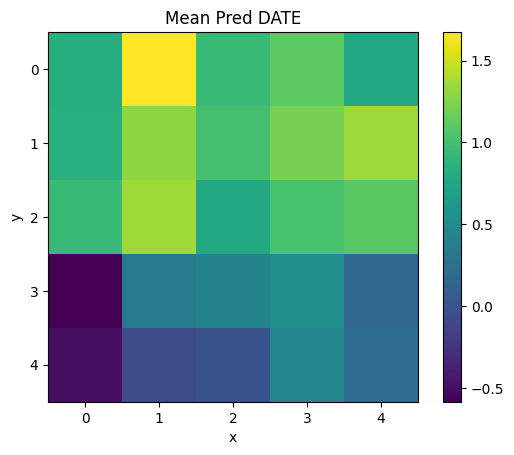

In [ ]:
pred_att = cf_pred_r_28[:3998,10:15, 10:15] - test_pred_r_28[:3998,10:15, 10:15]
mean_pred_att = np.mean(pred_att,axis=0)
print(np.mean(mean_pred_att))

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.imshow(mean_pred_att, cmap='viridis')
cbar = fig.colorbar(cax)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Mean Pred DATE')
plt.show()

7.735473186528701


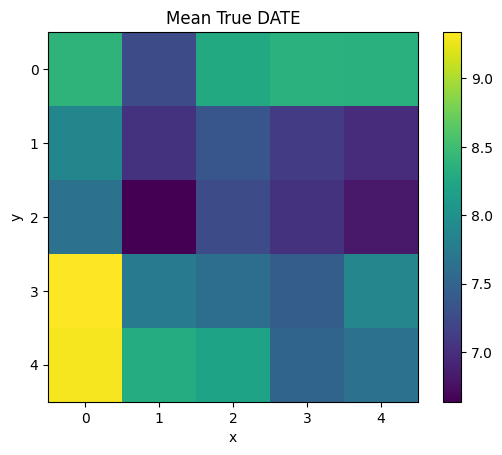

In [ ]:
true_att = data_wouts[2:,10:15, 10:15,4] - cf_pred_r_28[:3998,10:15, 10:15]
mean_true_att = np.mean(true_att,axis=0)
print(np.mean(mean_true_att))

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.imshow(mean_true_att, cmap='viridis')
cbar = fig.colorbar(cax)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Mean True DATE')
plt.show()